In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
import os
import fnmatch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import umap
from sklearn.mixture import GaussianMixture
from scipy import stats
# from sklearn.cluster import OPTICS

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.backend import mean
from tensorflow.keras.backend import square
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Flatten

from tensorflow.keras.utils import Sequence
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D
from scipy.stats import zscore

plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update(plt.rcParamsDefault)

np.random.seed(seed=11)


cwd = os.getcwd()

if cwd.split("/")[1] == "export":
    data_dir = "../../../files_from_snuffy"
else:
    data_dir = "../../../data_GRS1915"


/home/jkok1g14/anaconda3/envs/jakub-tf/lib/python3.5/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/jkok1g14/anaconda3/envs/jakub-tf/lib/python3.5/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/jkok1g14/anaconda3/envs/jakub-tf/lib/python3.5/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


# Load the model (shape)

In [2]:
weights_dir = "../../../model_weights/model_2020-04-29_09-12-23.h5"

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
    https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example"""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


original_dim = 128
intermediate_dim = 512
latent_dim = 16

# Define encoder model.
original_inputs = tf.keras.Input(shape=(original_dim,1), name='encoder_input')
input_err = Input(shape=(original_dim,1))
x = layers.CuDNNLSTM(intermediate_dim, return_sequences=False)(original_inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()((z_mean, z_log_var))
encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name='encoder')

# Define decoder model.
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.RepeatVector(original_dim)(latent_inputs)
x = layers.CuDNNLSTM(intermediate_dim, return_sequences=True)(x)
outputs = layers.TimeDistributed(layers.Dense(1))(x)
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name='decoder')

# Define VAE model.
outputs = decoder(z)
vae = tf.keras.Model(inputs=[original_inputs, input_err], outputs=outputs, name='vae')

vae.load_weights(weights_dir)

# Load data (segments)

In [3]:
segments_dir = '../../../data_GRS1915/468202_len128_s2_4cad_counts_errorfix.pkl'
errors_dir = '../../../data_GRS1915/468202_len128_s2_4cad_errors_errorfix.pkl'

with open(segments_dir, 'rb') as f:
    segments = pickle.load(f)
with open(errors_dir, 'rb') as f:
    errors = pickle.load(f)


# errors = ((errors)/np.expand_dims(np.std(segments, axis=1), axis=1)).astype(np.float32)
# segments = zscore(segments, axis=1).astype(np.float32)  # standardize per segment

# Encode the synthetic time series

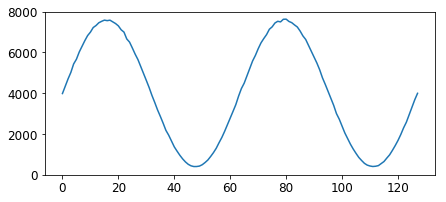

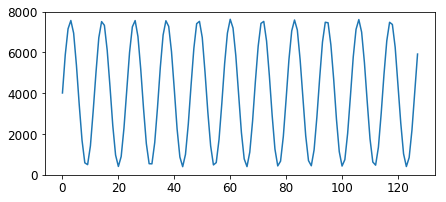

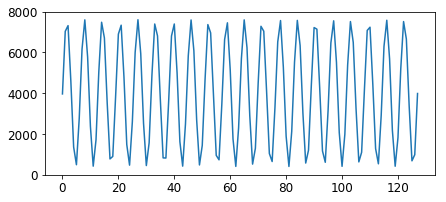

In [49]:
# from scipy import signal
# import matplotlib.pyplot as plt
# t = np.linspace(0, 1, 500)
# plt.plot(t, signal.sawtooth(2 * np.pi * 5 * t))
# plt.plot(t, signal.square(2 * np.pi * 5 * t))
plt.rcParams['figure.figsize'] =[7,3]

sine_freq_set = np.zeros((100,128,1))
for wave_ind, wave_cycles in enumerate(np.linspace(4,40,100)):
    sine_freq_set[wave_ind,:,0] = np.sin(np.linspace(0, np.pi*wave_cycles, 128))*1800+2000
    sine_freq_set[wave_ind,:,0] += np.random.normal(loc=sine_freq_set[wave_ind,:,0], scale=np.sqrt(sine_freq_set[wave_ind,:,0])/2)
    
plt.plot(sine_freq_set[0])
plt.ylim([0,8000])
plt.show()
plt.plot(sine_freq_set[50])
plt.ylim([0,8000])
plt.show()
plt.plot(sine_freq_set[99])
plt.ylim([0,8000])
plt.show()

In [5]:
set_to_encode=zscore(sine_freq_set, axis=1).astype(np.float32)

trained_encoder = tf.keras.Model(inputs=vae.input, outputs=[vae.get_layer("z_mean").output, vae.get_layer("z_log_var").output])
synthetic_encoding = np.zeros((set_to_encode.shape[0], 2, 16))
for seg_ind, seg in enumerate(set_to_encode):
    prediction = trained_encoder.predict([np.expand_dims(seg, axis=0), np.expand_dims(np.sqrt(seg)/2, axis=0)])
    synthetic_encoding[seg_ind][0] = prediction[0].flatten()
    synthetic_encoding[seg_ind][1] = prediction[1].flatten()
    print(seg_ind)
    clear_output(wait=True)
    

99


In [6]:
with open('{}/468202_len128_s2_4cad_counts_errorfix.pkl'.format(data_dir), 'rb') as f:
    segments_counts = pickle.load(f)

weights_dir = "../../../model_weights/model_2020-04-29_09-12-23.h5"
segments_dir = '../../../data_GRS1915/468202_len128_s2_4cad_counts_errorfix.pkl'
segment_encoding_dir = '{}/segment_encoding_{}_segments_{}.pkl'.format(data_dir, weights_dir.split("/")[-1].split(".")[0], segments_dir.split("/")[-1].split(".")[0])

with open(segment_encoding_dir, 'rb') as f:
    segment_encoding = pickle.load(f)
    
means_stds_code = (np.mean(segment_encoding[:,0,:], axis=0), np.std(segment_encoding[:,0,:], axis=0))

desc_stats = np.zeros((len(segments_counts), 4)) #mean, std, skew, kurt
# desc_stats[:,0] = np.median(segments_counts, axis=1).flatten()
desc_stats[:,0] = np.mean(segments_counts, axis=1).flatten()
desc_stats[:,1] = np.std(segments_counts, axis=1).flatten()
desc_stats[:,2] = stats.skew(segments_counts, axis=1).flatten()
desc_stats[:,3] = stats.kurtosis(segments_counts, axis=1).flatten()

means_stds_stats = (np.mean(desc_stats, axis=0), np.std(desc_stats, axis=0))

# zscore_desc_stats = zscore(desc_stats, axis=0)

# # desc_GM = np.hstack((zscore(desc_stats, axis=0), GMM_bics))

# shape_moments = np.hstack((segment_encoding_scaled_means, zscore_desc_stats)) # every column is standardized

In [7]:
synthetic_counts = sine_freq_set

synth_desc_stats = np.zeros((len(synthetic_counts), 4)) #mean, std, skew, kurt
synth_desc_stats[:,0] = np.mean(synthetic_counts, axis=1).flatten()
synth_desc_stats[:,1] = np.std(synthetic_counts, axis=1).flatten()
synth_desc_stats[:,2] = stats.skew(synthetic_counts, axis=1).flatten()
synth_desc_stats[:,3] = stats.kurtosis(synthetic_counts, axis=1).flatten()

synth_desc_stats_zscored = (synth_desc_stats-means_stds_stats[0])/means_stds_stats[1]
synthetic_encoding_zscored = (synthetic_encoding[:,0,:]-means_stds_code[0])/means_stds_code[1]

synth_shape_moments = np.hstack((synthetic_encoding_zscored, synth_desc_stats_zscored)) # every column is standardized

In [9]:
synth_shape_moments.shape

(100, 20)

In [11]:
with open('{}/UMAP_transformed_20d_shape16_moments4_trainedonall_468202.pkl'.format(data_dir), 'rb') as f:
    umaped_data = pickle.load(f)

In [10]:
with open('{}/UMAPmapper_20d_shape16_moments4_trainedonall_468202.pkl'.format(data_dir), 'rb') as f:
    UMAP_mapper = pickle.load(f)

In [15]:
umaped_synths = UMAP_mapper.transform(synth_shape_moments)

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


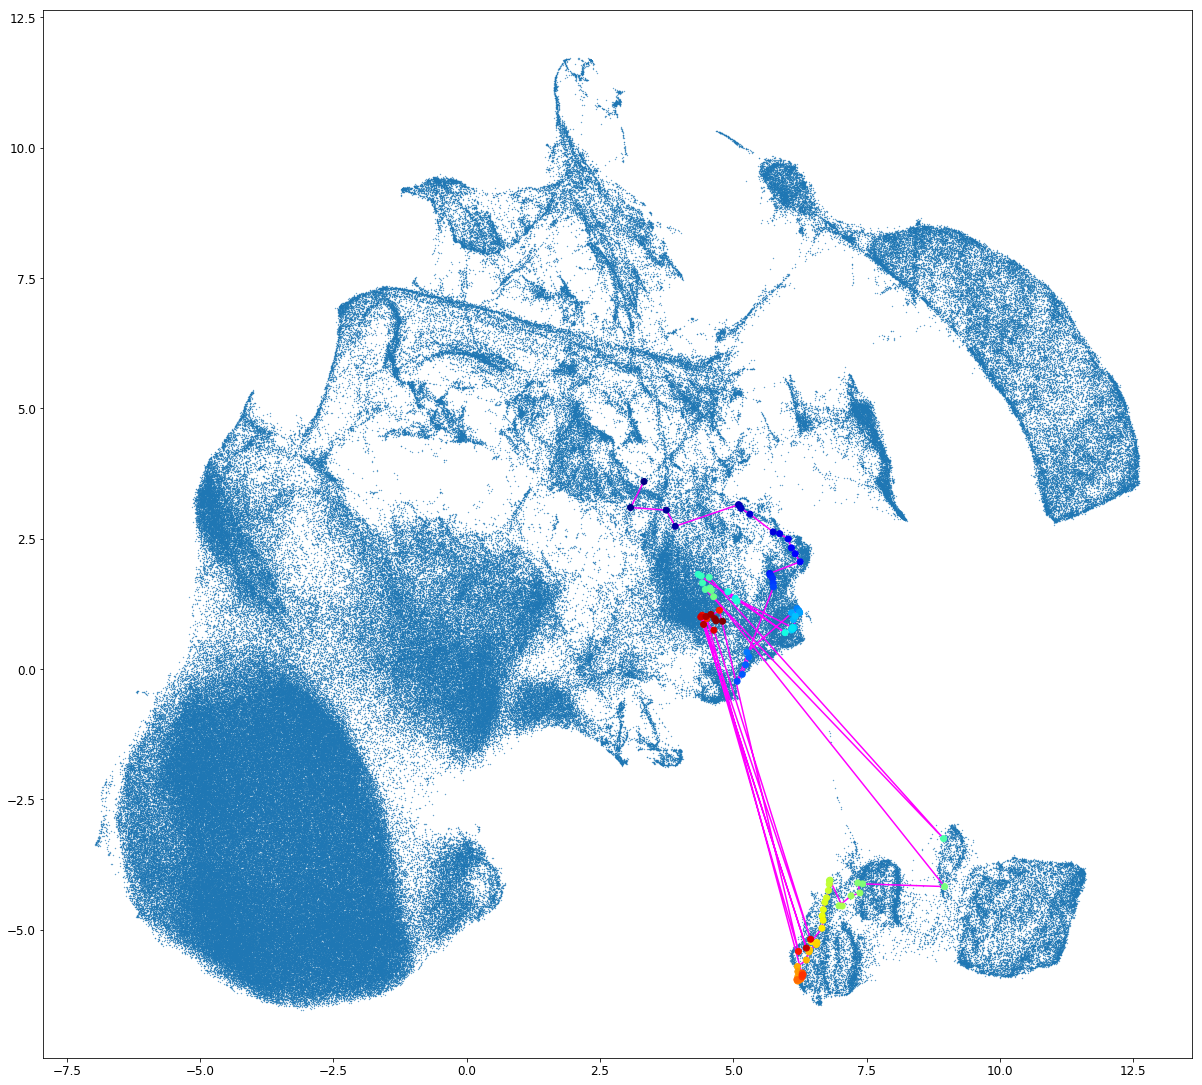

In [45]:
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = (abs((np.min(umaped_data[:,0])-0.5) -(np.max(umaped_data[:,0])+0.5)), abs((np.min(umaped_data[:,1])-0.5)- (np.max(umaped_data[:,1])+0.5)))
# plt.xlim([np.min(umaped_data[:,0])-0.5, np.max(umaped_data[:,0])+0.5])
# plt.ylim([np.min(umaped_data[:,1])-0.5, np.max(umaped_data[:,1])+0.5])
plt.scatter(umaped_data[:,0], umaped_data[:,1], s=0.1)
plt.plot(umaped_synths[:,0], umaped_synths[:,1], c="magenta",zorder=1)

plt.scatter(umaped_synths[:,0], umaped_synths[:,1], c=np.linspace(0,1,100),cmap="jet",zorder=2)
plt.show()

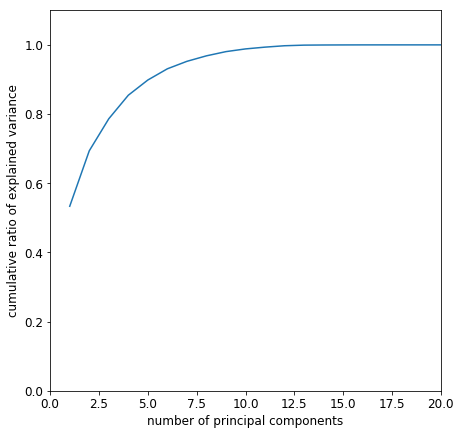

In [41]:
plt.rcParams['figure.figsize'] =[7,7]
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(synth_shape_moments)

plt.plot(np.array(range(20))+1,np.cumsum(pca.explained_variance_ratio_))
plt.ylim([0,1.1])
plt.xlim([0,20])
plt.ylabel("cumulative ratio of explained variance")
plt.xlabel("number of principal components")
plt.show()

In [50]:
np.cumsum(pca.explained_variance_ratio_)

array([0.53347506, 0.69372655, 0.78638773, 0.85446052, 0.89844631,
       0.93084745, 0.95241939, 0.96831677, 0.98049287, 0.98832057,
       0.99345995, 0.99748253, 0.99923422, 0.999646  , 0.9998333 ,
       0.99995861, 0.99998106, 0.99999871, 0.99999972, 1.        ])

In [60]:
synth_shape_moments.max(axis=0)/pca.components_[0]#4.89082786 positive minimum
synth_shape_moments.min(axis=0)/pca.components_[0]#-6.65042967 negative maximum

array([    6.84603444,    -9.38550313,    -7.39985628,   -10.0082686 ,
          -7.10600187,    14.58275215,    20.51919683,   -89.59373481,
        -386.39108847,     9.09824115,   -32.58327192,   -14.09544497,
          11.85463137,    -6.65042967,    10.54605354,     7.58970505,
         164.88557755, -3813.34828765,   116.33951589, -1377.77103759])

In [56]:
synth_shape_moments.max(axis=0)

array([ 2.62557271,  2.35439001,  2.02203402,  1.65659847,  2.39238428,
        4.07835892,  1.88518446,  1.89862802,  2.73490571,  2.79307099,
        2.56683542,  0.98795314,  1.4058289 ,  3.98786244,  2.48924825,
        2.71525383,  1.62733794,  4.05584043, -0.64476611, -1.00187639])

In [62]:
freq_axis_points = np.zeros((100,20))
for point_ind, magnitude in enumerate(np.linspace(-6.65042967, 4.89082786, 100)):
    freq_axis_points[point_ind] = pca.components_[0]*magnitude

In [63]:
freq_axis_points

array([[ 1.17270452, -1.70656448, -1.90036085, ...,  0.00677102,
         0.06013259, -0.00527978],
       [ 1.15214765, -1.67664935, -1.86704857, ...,  0.00665233,
         0.0590785 , -0.00518723],
       [ 1.13159079, -1.64673422, -1.8337363 , ...,  0.00653363,
         0.05802441, -0.00509468],
       ...,
       [-0.82131114,  1.1952034 ,  1.33092993, ..., -0.00474213,
        -0.04211425,  0.00369773],
       [-0.841868  ,  1.22511853,  1.3642422 , ..., -0.00486082,
        -0.04316834,  0.00379028],
       [-0.86242487,  1.25503367,  1.39755448, ..., -0.00497951,
        -0.04422243,  0.00388283]])

In [64]:
umaped_freq_axis = UMAP_mapper.transform(freq_axis_points)

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


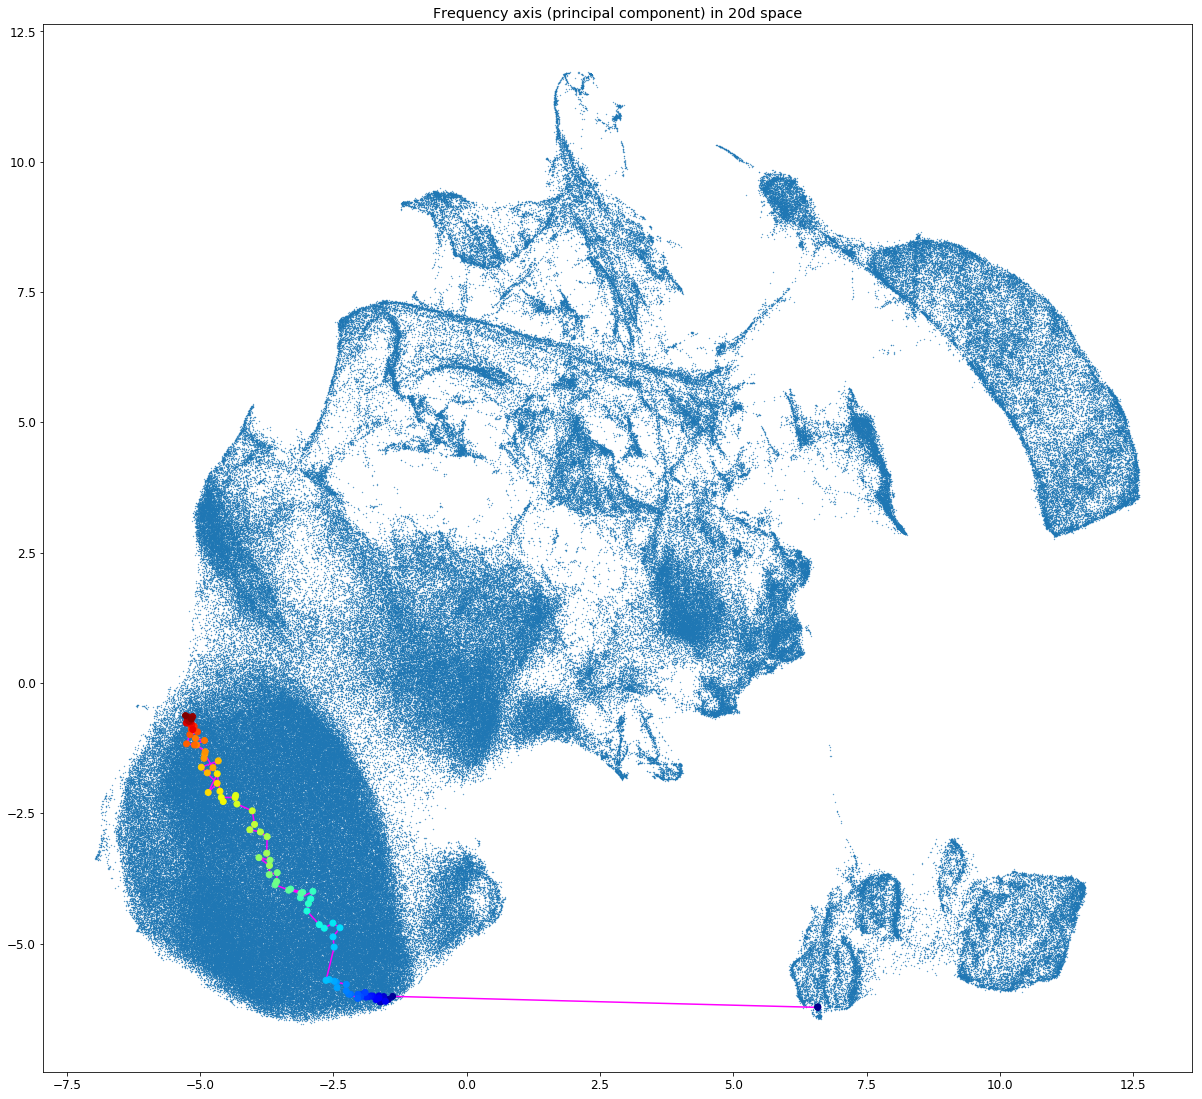

In [66]:
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = (abs((np.min(umaped_data[:,0])-0.5) -(np.max(umaped_data[:,0])+0.5)), abs((np.min(umaped_data[:,1])-0.5)- (np.max(umaped_data[:,1])+0.5)))
# plt.xlim([np.min(umaped_data[:,0])-0.5, np.max(umaped_data[:,0])+0.5])
# plt.ylim([np.min(umaped_data[:,1])-0.5, np.max(umaped_data[:,1])+0.5])
plt.scatter(umaped_data[:,0], umaped_data[:,1], s=0.1)
plt.plot(umaped_freq_axis[:,0], umaped_freq_axis[:,1], c="magenta",zorder=1)

plt.scatter(umaped_freq_axis[:,0], umaped_freq_axis[:,1], c=np.linspace(0,1,100),cmap="jet",zorder=2)
plt.title("Frequency axis (principal component) in 20d space")
plt.show()